In [ ]:
#################################
# model train
#################################

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import sklearn
import json
import random
import sklearn.ensemble
from scipy import stats

from FUNCs import plot_mds

class Data(object): 
    def __init__(self):
        pass
    
Data.X = Data()
Data.X.train = pd.read_csv('./train_GSE36961.csv', index_col=0)
Data.X.test = pd.read_csv('./test_rna_seq_data.csv', index_col=0)
Data.X.test_strange = pd.read_csv('./test_GSE1145_extension_target.csv', index_col=0)
Data.y = Data()
Data.y.train = list(pd.read_csv('./train_GSE36961_target.csv').iloc[:,1])
Data.y.test = list(pd.read_csv('./test_rna_seq_target.csv').iloc[:,1])
Data.y.test_strange = list(pd.read_csv('./test_GSE1145_extension_target.csv').iloc[:,1])

best_features = list(pd.read_csv('./best_features.csv').iloc[:,0])

with open('./top_gene_weight.json') as json_file:
    gene_weight = json.load(json_file)
    
gene_weight = dict(sorted(gene_weight.items(), key=lambda item: item[1], reverse=True))

def plot_corr(features):
    X = Data.X.train.transpose().filter(features, axis=1)
    y = np.array(Data.y.train)
    X = X.iloc[y != 1,:]
    
    corr = X.corr()
    ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
    ax.set_xticklabels( 
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [150]:
params = {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.7278953843983146}
model = LogisticRegression(**params)
model = make_pipeline(StandardScaler(), LogisticRegression())

In [164]:
from sklearn.utils import resample

class Bootstrap:
    
    '''Bootstrap cross validator.'''
    
    def __init__(self,n_bootstraps=5):
        self.nb = n_bootstraps
    
    def split(self, X, y=None):
        '''"""Generate indices to split data into training and test set.'''
        iX = np.mgrid[0:X.shape[0]]
        for i in range(self.nb):
            train = resample(iX)
            test = [item for item in iX if item not in train]
            yield (train,test)
            
class FeatureTester:

    def __init__(self, X, y, model, features, n_iter):
        self.X = X
        self.y = y
        self.features = features
        self.model = model
        self.n_iter = n_iter
        self.bob_feature = [] # best of the best feature
        
        self.last_addition_feature_ = str()
        self.last_removing_feature_ = str()
        
        self.brute_force_iter = len(features)*3 # для обрыва выполнения функции, когда она явно пойдет на третий круг

    def bootstrap_roc_auc(self, bf):
        
        """
        Функция получает набор фичей и выдает вектор бутстрепленных рок-аук-ов
        """

        Boot = Bootstrap(n_bootstraps=self.n_iter)

        X = self.X.filter(bf, axis=1)
        roc_auc = list()

        if len(bf) == 0:
            print('Base model estimated...')
        print(bf)
        for train, test in Boot.split(X):
            if X.shape[1] > 0:
                clfStack = self.model.fit(X.iloc[train, :], self.y[train])
                roc_auc.append(metrics.roc_auc_score(y_score=clfStack.predict(X.iloc[test, :]), y_true=self.y[test]))
            else:
                roc_auc.append(metrics.roc_auc_score(y_score=np.random.binomial(1, np.mean(self.y[test]), len(self.y[test])), y_true=self.y[test]))
        return roc_auc

    def feature_brute_force(self, test_features=None, derictional='append'):
        
        '''
        функция получает на вход вектор фичей, а далее по одной выкидывает или добавляем (из набора фичей в self.features) и тестирует, что из этого получилось
        '''

        roc_auc_pull = dict()
        print('directional = ', derictional, self.n_iter, ' iteraion')
        
        if derictional == 'remove': 
            for feature in ['all'] + test_features: # исключать фичи будем из переданного набора
                if feature == self.last_addition_feature_: continue # если фича была добавлена в набор на прошлом шаге, то её не удаляем 
                print(feature, '...', sep='')
                if feature != 'all':
                    bf = test_features.copy()
                    bf.remove(feature)
                else:
                    bf = test_features
                roc_auc_pull[feature] = self.bootstrap_roc_auc(bf=bf)
            return [roc_auc_pull, derictional]
        else:
            for feature in ['all'] + self.features: # для дабавление берем фичи из self.features
                if feature in test_features or feature == self.last_removing_feature_: continue # если фича уже есть в тестируемом наборе или была удалена их него на прошлом шаге, то её не добавляем 
                print(feature, '...', sep='')
                if feature != 'all':
                    bf = test_features.copy()
                    bf.append(feature)
                else:
                    bf = test_features
                roc_auc_pull[feature] = self.bootstrap_roc_auc(bf=bf)
            return [roc_auc_pull, derictional]

    @staticmethod
    def feature_stats(roc_auc_pull, derictional='remove', glob_direct='forward'):

        interest_feature = dict()

        # print('median(all) - median(-feature)', 'directional =', derictional, end='\n')
        
        print('curent roc_auc: ', np.median(roc_auc_pull['all']))

        for key in roc_auc_pull.keys():
            if key == 'all': continue
            pvalue = stats.mannwhitneyu(roc_auc_pull[key], roc_auc_pull['all']).pvalue
            feature_impact = np.median(roc_auc_pull['all']) - np.median(roc_auc_pull[key]) #если < 0 => модифицированный набор курче

            print(key, feature_impact, pvalue, sep='\t\t')
            
            if glob_direct == 'forward':
                if derictional == 'remove':
                    if feature_impact < 0:
                        interest_feature[key] = np.abs(feature_impact) # на самом деле это НЕинтересная фича, но для лаконичености сохраняется в тот же словарь
                elif derictional == 'append':
                    if pvalue < 0.05 and feature_impact < 0:
                        interest_feature[key] = np.abs(feature_impact)
            else:
                if derictional == 'remove':
                    if pvalue < 0.05 and feature_impact < 0:
                        interest_feature[key] = np.abs(feature_impact) # на самом деле это НЕинтересная фича, но для лаконичености сохраняется в тот же словарь
                elif derictional == 'append':
                    if feature_impact < 0:
                        interest_feature[key] = np.abs(feature_impact)

        return interest_feature
    
    def remove_feature_from_bob(self, interest_feature):
        influence_feature = list(dict(sorted(interest_feature.items(), key=lambda item: item[1], reverse=True)).keys())[0]
        self.bob_feature.remove(influence_feature)
        self.last_removing_feature_ = influence_feature # используем в feature_brute_force
        
    def append_feature_to_bob(self, interest_feature):
        influence_feature = list(dict(sorted(interest_feature.items(), key=lambda item: item[1], reverse=True)).keys())[0]
        self.bob_feature.append(influence_feature)
        self.last_addition_feature_ = influence_feature # используем в feature_brute_force
        
    def forward_find_min_feature_set(self):
        
        self.brute_force_iter -= 1
        if self.brute_force_iter == 0:
            print("Что-то не сошлось, я попал в бесконечный цикл...")
            return 1
        
        interest_feature = self.feature_stats(*self.feature_brute_force(test_features=self.bob_feature))
        
        print(interest_feature)
        
        if len(interest_feature.keys()) == 0:
            if len(self.bob_feature) != 0: # если какие-то фичи уже отобраны пробуем их прорядить
                interest_feature = self.feature_stats(*self.feature_brute_force(test_features=self.bob_feature, derictional='remove'))
                print('feature remove: ', interest_feature)
                if len(interest_feature.keys()) == 0:
                    print('done')
                    return 0
                else:
                    self.remove_feature_from_bob(interest_feature)
                    self.forward_find_min_feature_set()
            else: # если никаких фичей еще не отбрано, то проряжаем весь набор
                interest_feature = self.feature_stats(*self.feature_brute_force(test_features=self.features, derictional='remove'))
                if len(interest_feature.keys()) == 0:
                    print('Оо-оу не могу отобрать фичи...')
                    return 1
                else:
                    self.append_feature_to_bob(interest_feature)
                    self.forward_find_min_feature_set()
        else:
            self.append_feature_to_bob(interest_feature)
            self.forward_find_min_feature_set()
        
    def backward_find_min_feature_set(self):
        
        if self.brute_force_iter == 0:
            print("Что-то не сошлось, я попал в бесконечный цикл...")
            return 1
        
        if self.brute_force_iter == len(self.features)*3: # если мы находимся на первой итерации
            self.bob_feature = self.features.copy()
        
        self.brute_force_iter -= 1
        
        interest_feature = self.feature_stats(*self.feature_brute_force(test_features=self.bob_feature, derictional='remove'), glob_direct='backward')
        
        print(interest_feature)
        
        if len(interest_feature.keys()) == 0:
            if len(self.bob_feature) != len(self.features): # если какие-то фичи уже были выброшены пробуем их добавить обратно
                interest_feature = self.feature_stats(*self.feature_brute_force(test_features=self.bob_feature, derictional='append'))
                if len(interest_feature.keys()) == 0:
                    print('done')
                    return 0
                else:
                    print('feature for appending: ', interest_feature)
                    self.append_feature_to_bob(interest_feature)
                    self.backward_find_min_feature_set()
            else: # если никакие фичей еще не были выброшены
                print('Оо-оу не могу отобрать фичи...')
                return 1
        else:
            self.remove_feature_from_bob(interest_feature)
            self.backward_find_min_feature_set()
            

In [179]:
best_features.remove('CDC42EP4')

In [180]:
ft = FeatureTester(Data.X.train.transpose(), np.array(Data.y.train), model, best_features, 300)

In [181]:
ft.forward_find_min_feature_set()

directional =  append 300  iteraion
all...
Base model estimated...
[]
ZFP36...
['ZFP36']
FCN3...
['FCN3']
MT1M...
['MT1M']
RASD1...
['RASD1']
C1R...
['C1R']
PRKCD...
['PRKCD']
CEBPD...
['CEBPD']
TUBA3C...
['TUBA3C']
MYH6...
['MYH6']
TUBA3E...
['TUBA3E']
curent roc_auc:  0.48910492660492655
ZFP36		-0.4428845020950285		5.248727754942805e-100
FCN3		-0.4339719964719966		5.171699078777978e-100
MT1M		-0.40375221625221624		5.215353546713746e-100
RASD1		-0.4305236533817097		5.26921623391719e-100
C1R		-0.4223635069223305		5.254606395216949e-100
PRKCD		-0.4199048136548137		5.259307427775243e-100
CEBPD		-0.44905066780066794		5.22668364865224e-100
TUBA3C		-0.4608950733950735		5.057302874135073e-100
MYH6		-0.4442284067284068		5.132225432190073e-100
TUBA3E		-0.45207154398330873		5.212810075482993e-100
{'ZFP36': 0.4428845020950285, 'FCN3': 0.4339719964719966, 'MT1M': 0.40375221625221624, 'RASD1': 0.4305236533817097, 'C1R': 0.4223635069223305, 'PRKCD': 0.4199048136548137, 'CEBPD': 0.44905066780066794,

In [182]:
ft.bob_feature

['TUBA3C', 'C1R', 'RASD1', 'MYH6']

In [175]:
ft.bob_feature

['CDC42EP4', 'PRKCD', 'C1R']

In [178]:
ft.bob_feature

['CDC42EP4', 'PRKCD', 'C1R']

In [171]:
best_features

['ZFP36',
 'FCN3',
 'MT1M',
 'RASD1',
 'C1R',
 'CDC42EP4',
 'PRKCD',
 'CEBPD',
 'TUBA3C',
 'MYH6',
 'TUBA3E']

In [82]:
models = list()
for i in range(10):
    ft = FeatureTester(Data.X.train.transpose(), np.array(Data.y.train), model, best_features, 100)
    ft.find_minimal_feature_set()
    models.append(ft.bob_feature)

directional =  append 100  iteraion
all...
Base model estimated...
[]
ZFP36...
['ZFP36']
FCN3...
['FCN3']
MT1M...
['MT1M']
RASD1...
['RASD1']
C1R...
['C1R']
CDC42EP4...
['CDC42EP4']
PRKCD...
['PRKCD']
CEBPD...
['CEBPD']
TUBA3C...
['TUBA3C']
MYH6...
['MYH6']
TUBA3E...
['TUBA3E']
curent roc_auc:  0.5060515515875873
ZFP36		0.0060515515875873005		0.1801207679384565
FCN3		0.0060515515875873005		0.1801207679384565
MT1M		0.0060515515875873005		0.1801207679384565
RASD1		0.0060515515875873005		0.1801207679384565
C1R		0.0060515515875873005		0.1801207679384565
CDC42EP4		0.0060515515875873005		0.1801207679384565
PRKCD		0.0060515515875873005		0.1801207679384565
CEBPD		0.0060515515875873005		0.1801207679384565
TUBA3C		0.0060515515875873005		0.1801207679384565
MYH6		0.0060515515875873005		0.1801207679384565
TUBA3E		0.0060515515875873005		0.1801207679384565
{}
directional =  remove 100  iteraion
all...
['ZFP36', 'FCN3', 'MT1M', 'RASD1', 'C1R', 'CDC42EP4', 'PRKCD', 'CEBPD', 'TUBA3C', 'MYH6', 'TUBA3E']


ZFP36...
['CEBPD', 'ZFP36']
FCN3...
['CEBPD', 'FCN3']
MT1M...
['CEBPD', 'MT1M']
RASD1...
['CEBPD', 'RASD1']
C1R...
['CEBPD', 'C1R']
CDC42EP4...
['CEBPD', 'CDC42EP4']
PRKCD...
['CEBPD', 'PRKCD']
TUBA3C...
['CEBPD', 'TUBA3C']
MYH6...
['CEBPD', 'MYH6']
TUBA3E...
['CEBPD', 'TUBA3E']
curent roc_auc:  0.5
ZFP36		0.0		0.0002553024615165003
FCN3		0.0		0.15458378750383206
MT1M		-0.13636363636363635		1.0687583460560887e-38
RASD1		-0.3042164234114699		2.8195930193767757e-39
C1R		-0.12211538461538463		8.422134314151813e-38
CDC42EP4		-0.30000000000000004		2.8179352713951727e-39
PRKCD		-0.32464415017606507		2.818971252286885e-39
TUBA3C		0.0		4.221986847699079e-05
MYH6		-0.17446018893387316		2.8198003048388453e-39
TUBA3E		0.0		0.08839977266267829
{'MT1M': 0.13636363636363635, 'RASD1': 0.3042164234114699, 'C1R': 0.12211538461538463, 'CDC42EP4': 0.30000000000000004, 'PRKCD': 0.32464415017606507, 'MYH6': 0.17446018893387316}
directional =  append 100  iteraion
all...
['CEBPD', 'PRKCD']
ZFP36...
['CEBPD'

C1R...
['CEBPD', 'C1R']
CDC42EP4...
['CEBPD', 'CDC42EP4']
PRKCD...
['CEBPD', 'PRKCD']
TUBA3C...
['CEBPD', 'TUBA3C']
MYH6...
['CEBPD', 'MYH6']
TUBA3E...
['CEBPD', 'TUBA3E']
curent roc_auc:  0.5
ZFP36		0.0		0.0006153132693573369
FCN3		0.0		0.04482773288338549
MT1M		-0.14072228081516003		2.0228834877245065e-36
RASD1		-0.3057178932178932		2.8115204851086863e-39
C1R		-0.11726190476190479		2.8193857487981478e-39
CDC42EP4		-0.29568789054083155		2.8185568152966837e-39
PRKCD		-0.32585013670539986		2.818764026352249e-39
TUBA3C		0.0		0.00011491058379064946
MYH6		-0.18088816827926912		2.818764026352249e-39
TUBA3E		0.0		0.32736046439419686
{'MT1M': 0.14072228081516003, 'RASD1': 0.3057178932178932, 'C1R': 0.11726190476190479, 'CDC42EP4': 0.29568789054083155, 'PRKCD': 0.32585013670539986, 'MYH6': 0.18088816827926912}
directional =  append 100  iteraion
all...
['CEBPD', 'PRKCD']
ZFP36...
['CEBPD', 'PRKCD', 'ZFP36']
FCN3...
['CEBPD', 'PRKCD', 'FCN3']
MT1M...
['CEBPD', 'PRKCD', 'MT1M']
RASD1...
['CEBPD'

ZFP36...
['TUBA3E', 'PRKCD', 'ZFP36']
FCN3...
['TUBA3E', 'PRKCD', 'FCN3']
MT1M...
['TUBA3E', 'PRKCD', 'MT1M']
RASD1...
['TUBA3E', 'PRKCD', 'RASD1']
C1R...
['TUBA3E', 'PRKCD', 'C1R']
CDC42EP4...
['TUBA3E', 'PRKCD', 'CDC42EP4']
CEBPD...
['TUBA3E', 'PRKCD', 'CEBPD']
TUBA3C...
['TUBA3E', 'PRKCD', 'TUBA3C']
MYH6...
['TUBA3E', 'PRKCD', 'MYH6']
curent roc_auc:  0.8454861111111112
ZFP36		-0.04436776261373043		7.816428031608564e-10
FCN3		-0.04079208437761084		0.0001034796127322457
MT1M		-0.02784248063853323		0.0012035921661161446
RASD1		-0.10202288573999096		3.6930468261147086e-25
C1R		-0.0042548011298011446		0.48635576281925036
CDC42EP4		-0.020208651642475095		0.03674310377541128
CEBPD		-0.035301845963610634		7.652577977856852e-05
TUBA3C		-0.04393768768768769		8.027048972130286e-07
MYH6		-6.467956163069832e-05		0.2535418271345631
{'ZFP36': 0.04436776261373043, 'FCN3': 0.04079208437761084, 'MT1M': 0.02784248063853323, 'RASD1': 0.10202288573999096, 'CDC42EP4': 0.020208651642475095, 'CEBPD': 0.03

MYH6...
['MYH6']
TUBA3E...
['TUBA3E']
curent roc_auc:  0.5137759527294411
ZFP36		0.013775952729441099		0.00646728437734322
FCN3		0.013775952729441099		0.00646728437734322
MT1M		0.013775952729441099		0.00646728437734322
RASD1		0.013775952729441099		0.00646728437734322
C1R		0.013775952729441099		0.00646728437734322
CDC42EP4		0.013775952729441099		0.00646728437734322
PRKCD		0.013775952729441099		0.00646728437734322
CEBPD		0.013775952729441099		0.00646728437734322
TUBA3C		0.013775952729441099		0.00646728437734322
MYH6		0.013775952729441099		0.00646728437734322
TUBA3E		0.013775952729441099		0.00646728437734322
{}
directional =  remove 100  iteraion
all...
['ZFP36', 'FCN3', 'MT1M', 'RASD1', 'C1R', 'CDC42EP4', 'PRKCD', 'CEBPD', 'TUBA3C', 'MYH6', 'TUBA3E']
ZFP36...
['FCN3', 'MT1M', 'RASD1', 'C1R', 'CDC42EP4', 'PRKCD', 'CEBPD', 'TUBA3C', 'MYH6', 'TUBA3E']
FCN3...
['ZFP36', 'MT1M', 'RASD1', 'C1R', 'CDC42EP4', 'PRKCD', 'CEBPD', 'TUBA3C', 'MYH6', 'TUBA3E']
MT1M...
['ZFP36', 'FCN3', 'RASD1', 'C1R',

ZFP36...
['TUBA3E', 'ZFP36']
FCN3...
['TUBA3E', 'FCN3']
MT1M...
['TUBA3E', 'MT1M']
RASD1...
['TUBA3E', 'RASD1']
C1R...
['TUBA3E', 'C1R']
CDC42EP4...
['TUBA3E', 'CDC42EP4']
PRKCD...
['TUBA3E', 'PRKCD']
CEBPD...
['TUBA3E', 'CEBPD']
TUBA3C...
['TUBA3E', 'TUBA3C']
MYH6...
['TUBA3E', 'MYH6']
curent roc_auc:  0.5
ZFP36		0.0		0.0001862911749936083
FCN3		0.0		0.09738070804476523
MT1M		-0.05902777777777779		8.76490357103862e-28
RASD1		-0.20627815315315323		2.818971252286885e-39
C1R		-0.16666666666666674		2.8173138613691015e-39
CDC42EP4		-0.3126629029990373		2.8193857487981478e-39
PRKCD		-0.33654279279279276		2.818764026352249e-39
CEBPD		0.0		0.2828311878939613
TUBA3C		0.0		5.001279334990988e-07
MYH6		-0.20710784313725483		2.8168996623796895e-39
{'MT1M': 0.05902777777777779, 'RASD1': 0.20627815315315323, 'C1R': 0.16666666666666674, 'CDC42EP4': 0.3126629029990373, 'PRKCD': 0.33654279279279276, 'MYH6': 0.20710784313725483}
directional =  append 100  iteraion
all...
['TUBA3E', 'PRKCD']
ZFP36...
['T

FCN3...
['ZFP36', 'FCN3']
MT1M...
['ZFP36', 'MT1M']
RASD1...
['ZFP36', 'RASD1']
C1R...
['ZFP36', 'C1R']
CDC42EP4...
['ZFP36', 'CDC42EP4']
PRKCD...
['ZFP36', 'PRKCD']
CEBPD...
['ZFP36', 'CEBPD']
TUBA3C...
['ZFP36', 'TUBA3C']
MYH6...
['ZFP36', 'MYH6']
TUBA3E...
['ZFP36', 'TUBA3E']
curent roc_auc:  0.5
FCN3		0.0		0.12562715281028874
MT1M		-0.09945799457994586		1.0632799328056304e-33
RASD1		-0.2807819429336458		2.8175209831710998e-39
C1R		-0.11909722222222219		6.132374572220628e-35
CDC42EP4		-0.3218253968253968		2.8191784931018382e-39
PRKCD		-0.3209665334665335		2.8191784931018382e-39
CEBPD		0.0		0.02776113729001056
TUBA3C		0.0		0.024629305962766655
MYH6		-0.12395047762694822		2.3505866416085786e-36
TUBA3E		0.0		0.0066365182620316135
{'MT1M': 0.09945799457994586, 'RASD1': 0.2807819429336458, 'C1R': 0.11909722222222219, 'CDC42EP4': 0.3218253968253968, 'PRKCD': 0.3209665334665335, 'MYH6': 0.12395047762694822}
directional =  append 100  iteraion
all...
['ZFP36', 'CDC42EP4']
FCN3...
['ZFP36', 

FCN3...
['FCN3']
MT1M...
['MT1M']
RASD1...
['RASD1']
C1R...
['C1R']
CDC42EP4...
['CDC42EP4']
PRKCD...
['PRKCD']
CEBPD...
['CEBPD']
TUBA3C...
['TUBA3C']
MYH6...
['MYH6']
TUBA3E...
['TUBA3E']
curent roc_auc:  0.5009157509157509
ZFP36		0.0009157509157509125		0.3970285853413107
FCN3		0.0009157509157509125		0.3970285853413107
MT1M		0.0009157509157509125		0.3970285853413107
RASD1		0.0009157509157509125		0.3970285853413107
C1R		0.0009157509157509125		0.3970285853413107
CDC42EP4		0.0009157509157509125		0.3970285853413107
PRKCD		0.0009157509157509125		0.3970285853413107
CEBPD		0.0009157509157509125		0.3970285853413107
TUBA3C		0.0009157509157509125		0.3970285853413107
MYH6		0.0009157509157509125		0.3970285853413107
TUBA3E		0.0009157509157509125		0.3970285853413107
{}
directional =  remove 100  iteraion
all...
['ZFP36', 'FCN3', 'MT1M', 'RASD1', 'C1R', 'CDC42EP4', 'PRKCD', 'CEBPD', 'TUBA3C', 'MYH6', 'TUBA3E']
ZFP36...
['FCN3', 'MT1M', 'RASD1', 'C1R', 'CDC42EP4', 'PRKCD', 'CEBPD', 'TUBA3C', 'MYH6',

In [83]:
models

[['TUBA3E', 'PRKCD', 'RASD1'],
 ['PRKCD', 'RASD1', 'TUBA3C'],
 ['PRKCD', 'RASD1', 'TUBA3C'],
 ['TUBA3E', 'PRKCD', 'RASD1'],
 ['TUBA3C', 'PRKCD', 'RASD1'],
 ['TUBA3C', 'PRKCD', 'RASD1'],
 ['TUBA3E', 'PRKCD', 'RASD1'],
 [],
 ['CDC42EP4', 'RASD1', 'TUBA3C', 'PRKCD', 'FCN3', 'MYH6'],
 ['PRKCD', 'RASD1', 'TUBA3C']]

In [44]:
ft.bob_feature

['RASD1', 'PRKCD', 'TUBA3C']

In [1578]:
ft.bob_feature

['MYH6', 'MT1M']

In [1334]:
feature_stats(*[test, 'append'])

median(all) - median(-feature) directional = append
all		0.0		0.49982745687803415
RASD1		0.07227403156384504		3.157824037953675e-35
CDC42EP4		-0.0018002322880371624		0.3226914759472679
PRKCD		0.030642274392274405		2.16756983845786e-07
CEBPD		-0.006361371186952569		0.0668721756242056
TUBA3E		0.01776348651348647		0.00018437051490165853


[]

In [1384]:
test = bootstrap_model_test(model, best_features, n_iter=200)

directional =  remove 200  iteraion
all...
ZFP36...
FCN3...
MT1M...
RASD1...
C1R...
CDC42EP4...
PRKCD...
CEBPD...
TUBA3C...
MYH6...
TUBA3E...


In [1312]:
_best_features = feature_stats(test)

median(all) - median(-feature) directional = remove
all		0.0		0.4998274496944693
ZFP36		-5.5708764268747046e-05		0.3032346811577207
FCN3		0.0033544580419582193		0.1576082504877117
MT1M		-2.812502812499229e-05		0.4682851956213704
RASD1		0.061491286491286656		9.088302592055965e-23
C1R		-0.0001498501498500282		0.4725865535097207
CDC42EP4		0.009446109446109574		0.011504928496412893
PRKCD		0.03987408360473399		2.1308532425367692e-14
CEBPD		0.0006849026126873881		0.3884737953371693
TUBA3C		0.0026085026085027607		0.3518966218279457
MYH6		0.003130641288536129		0.11088330032214
TUBA3E		-0.0037692062440983776		0.4316607177632748


In [1317]:
test_add = bootstrap_model_test(model, best_features, _best_features, 200, 'append')

directional =  append 200  iteraion
all...
ZFP36...
FCN3...
MT1M...
RASD1...
C1R...
CDC42EP4...
PRKCD...
CEBPD...
TUBA3C...
MYH6...
TUBA3E...


In [1318]:
feature_stats(test_add, 'append')

median(all) - median(-feature) directional = append
all		0.0		0.49982746522537425
ZFP36		-0.07012061403508763		8.915137311871505e-32
FCN3		-0.06015037593984962		1.3154369734211813e-24
MT1M		-0.06808688387635753		2.1286075696007257e-23
C1R		-0.06347919216646258		1.2851583755284472e-30
CEBPD		-0.07260671804735441		2.6285913014138717e-32
TUBA3C		-0.06478601807549178		2.1561371601918505e-27
MYH6		-0.07225646837682431		5.248437154600258e-32
TUBA3E		-0.05887713937249539		1.9298274530575756e-21


['ZFP36', 'FCN3', 'MT1M', 'C1R', 'CEBPD', 'TUBA3C', 'MYH6', 'TUBA3E']

In [1320]:
_best_features.append('CEBPD')

In [1321]:
test_add = bootstrap_model_test(model, best_features, _best_features, 200, 'append')

directional =  append 200  iteraion
all...
ZFP36...
FCN3...
MT1M...
RASD1...
C1R...
CDC42EP4...
PRKCD...
CEBPD...
TUBA3C...
MYH6...
TUBA3E...


In [1322]:
feature_stats(test_add, 'append')

median(all) - median(-feature) directional = append
all		0.0		0.4998274644489286
ZFP36		-0.012149859943977659		0.002013473179617755
FCN3		-0.030476927613150573		2.035251408571001e-08
MT1M		-0.01872852709486017		9.401965962669016e-06
C1R		-0.021313393778564005		4.589081114360132e-06
TUBA3C		-0.022680995475113153		7.69158774037803e-06
MYH6		-0.01678550207961982		9.436498404941256e-05
TUBA3E		-0.024754901960784337		5.821347092072755e-08


['ZFP36', 'FCN3', 'MT1M', 'C1R', 'TUBA3C', 'MYH6', 'TUBA3E']

In [1323]:
_best_features.append('TUBA3E')

In [1325]:
feature_stats(bootstrap_model_test(model, best_features, _best_features, 200, 'append'), 'append')

directional =  append 200  iteraion
all...
ZFP36...
FCN3...
MT1M...
RASD1...
C1R...
CDC42EP4...
PRKCD...
CEBPD...
TUBA3C...
MYH6...
TUBA3E...
median(all) - median(-feature) directional = append
all		0.0		0.49982745817227475
ZFP36		0.0		0.36678807034927663
FCN3		0.0002923976608187884		0.28874510853299046
MT1M		-0.0057539682539682335		0.06454975130536779
C1R		-0.0028846153846153744		0.1328836049750881
TUBA3C		0.001335957187021064		0.4605509281641645
MYH6		-0.004166666666666652		0.2218495232532992


[]

In [1327]:
test = bootstrap_model_test(model, _best_features, n_iter=200)

directional =  remove 200  iteraion
all...
RASD1...
CDC42EP4...
PRKCD...
CEBPD...
TUBA3E...


In [1328]:
feature_stats(test)

median(all) - median(-feature) directional = remove
all		0.0		0.49982745687803415
RASD1		0.07227403156384504		3.157824037953675e-35
CDC42EP4		-0.0018002322880371624		0.3226914759472679
PRKCD		0.030642274392274405		2.16756983845786e-07
CEBPD		-0.006361371186952569		0.0668721756242056
TUBA3E		0.01776348651348647		0.00018437051490165853


['RASD1', 'PRKCD', 'TUBA3E']

In [691]:
%%time

best_features = list(pd.read_csv('./best_features.csv').iloc[:,0])

roc_auc_pull = dict()
for feature in ['all'] + best_features:
    print(feature, '...', sep='')
    if feature != 'all':
        bf = best_features.copy()
        bf.remove(feature)
    else:
        bf = best_features

    Boot = Bootstrap(n_bootstraps=100)

    X = Data.X.train.transpose().filter(bf, axis=1)
    y = np.array(Data.y.train)
    roc_auc = list()
    
    for train, test in Boot.split(X):
        clfStack = clf.fit(X.iloc[train,:], y[train])
        roc_auc.append(metrics.roc_auc_score(y_score=clfStack.predict(X.iloc[test,:]), y_true=y[test]))
    
    roc_auc_pull[feature] = roc_auc

all...
ZFP36...
FCN3...
MT1M...
RASD1...
C1R...
CDC42EP4...
PRKCD...
CEBPD...
TUBA3C...
MYH6...
TUBA3E...
CPU times: user 58min 22s, sys: 5min 34s, total: 1h 3min 57s
Wall time: 8min 19s


In [701]:
best_o_best_feature = list()
for key in roc_auc_pull.keys():
    pvalue = stats.mannwhitneyu(roc_auc_pull[key], roc_auc_pull['all']).pvalue
    print(key, np.mean(roc_auc_pull[key]), sep='\t')
    
    if pvalue < 0.05 and np.mean(roc_auc_pull[key]) < np.mean(roc_auc_pull['all']):
        best_o_best_feature.append(key)

all	0.9393098015102013
ZFP36	0.933551125252099
MT1M	0.9433674750531864
RASD1	0.9018133926256631
C1R	0.9410067230388717
CDC42EP4	0.9370274286028111
PRKCD	0.909105125854295
CEBPD	0.9428523143199214
TUBA3C	0.9405288246040361
MYH6	0.928184097537443
TUBA3E	0.9414510577671069


In [703]:
%%time

best_features = list(pd.read_csv('./best_features.csv').iloc[:,0])

roc_auc_pull_app = dict()
for feature in ['all'] + best_features:
    print(feature, '...', sep='')
    if feature != 'all' and feature not in best_o_best_feature:
        bf = best_o_best_feature.copy()
        bf.append(feature)
    else:
        bf = best_o_best_feature

    Boot = Bootstrap(n_bootstraps=100)

    X = Data.X.train.transpose().filter(bf, axis=1)
    y = np.array(Data.y.train)
    roc_auc = list()
    
    for train, test in Boot.split(X):
        clfStack = clf.fit(X.iloc[train,:], y[train])
        roc_auc.append(metrics.roc_auc_score(y_score=clfStack.predict(X.iloc[test,:]), y_true=y[test]))
    
    roc_auc_pull_app[feature] = roc_auc

all...
ZFP36...
FCN3...
MT1M...
RASD1...
C1R...
CDC42EP4...
PRKCD...
CEBPD...
TUBA3C...
MYH6...
TUBA3E...
CPU times: user 57min 52s, sys: 6min 23s, total: 1h 4min 15s
Wall time: 8min 44s


all	0.9393098015102013	0.4995125918884118
ZFP36	0.933551125252099	0.0009936345215847615
FCN3	0.9360628699727875	2.234362992178085e-05
MT1M	0.9433674750531864	0.45864603774548096
RASD1	0.9018133926256631	0.17911965051132134
C1R	0.9410067230388717	0.10325077063237403
CDC42EP4	0.9370274286028111	0.3425160400539168
PRKCD	0.909105125854295	0.30564675008948694
CEBPD	0.9428523143199214	0.4591310530696697
TUBA3C	0.9405288246040361	2.3500745091820934e-08
MYH6	0.928184097537443	0.3702911611602359
TUBA3E	0.9414510577671069	4.205590911385969e-06


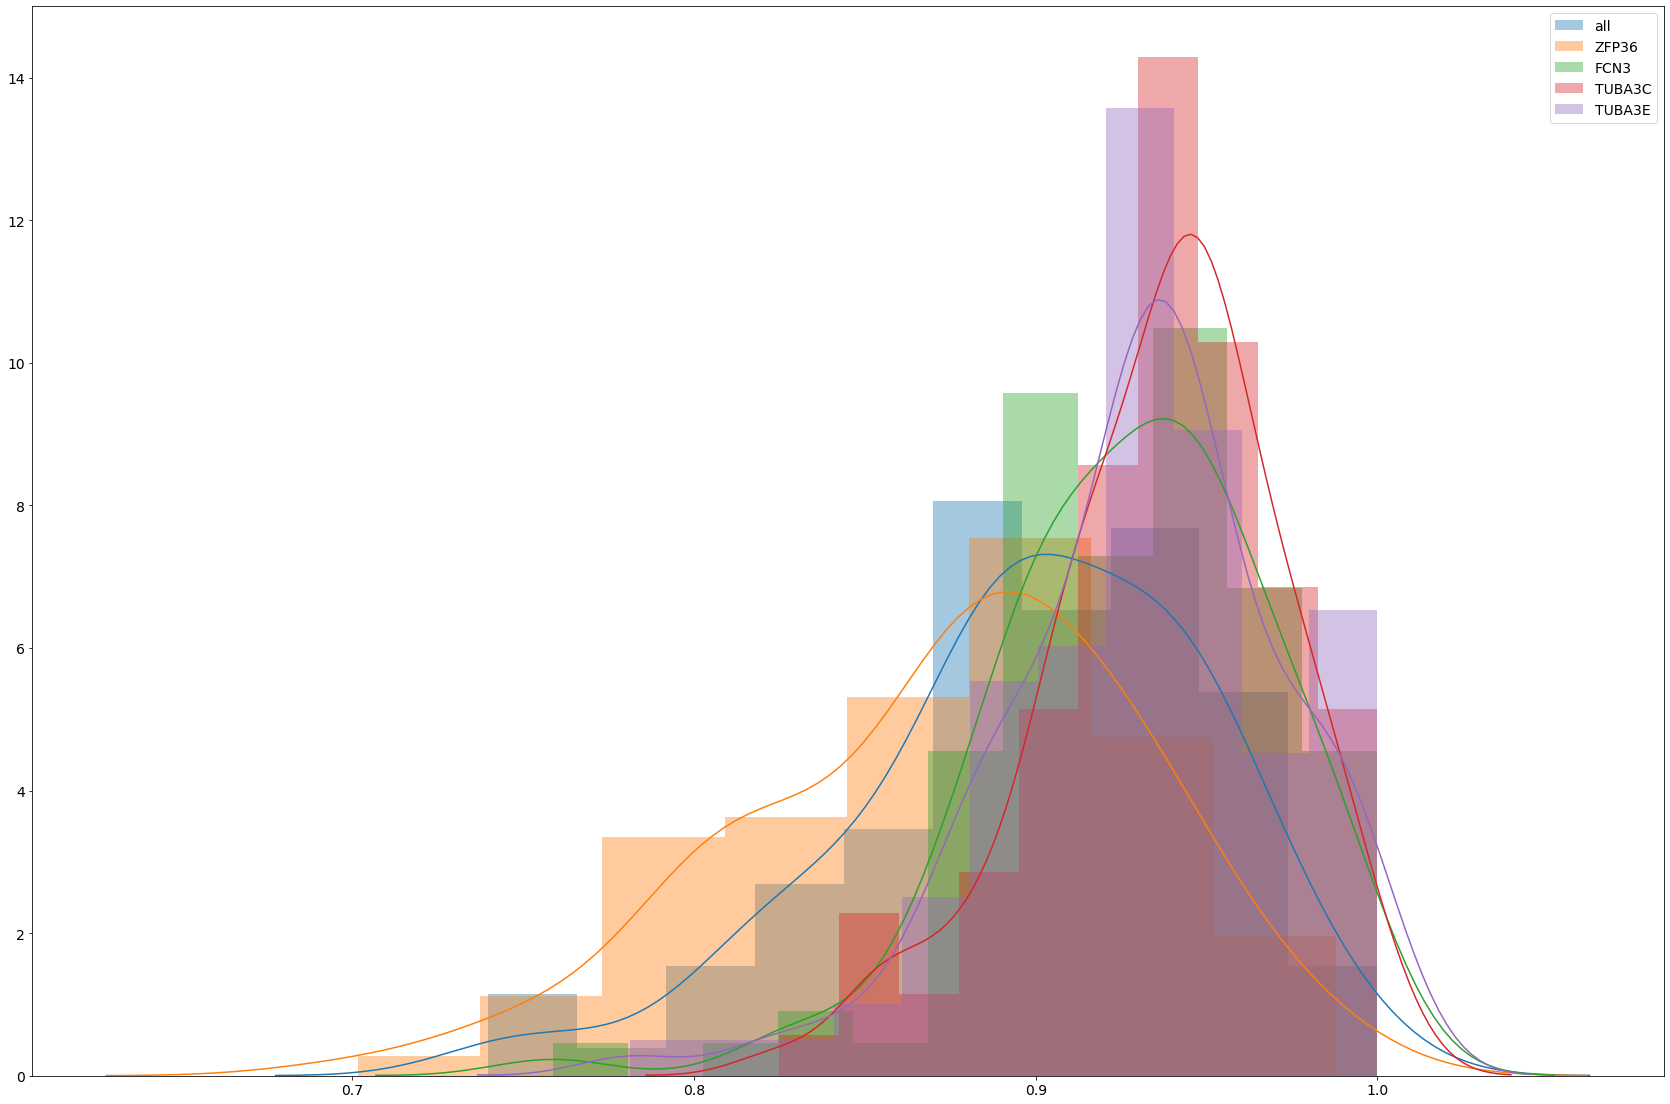

In [722]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize = (24,16))
fig.tight_layout(pad = 2, w_pad = 3)

for key in roc_auc_pull_app.keys():
    pvalue = stats.mannwhitneyu(roc_auc_pull_app[key], roc_auc_pull_app['all']).pvalue
    print(key, np.mean(roc_auc_pull[key]), pvalue,sep='\t')
    
    if pvalue < 0.05 or key == 'all':
        sns.distplot(roc_auc_pull_app[key], label=key)
        axes.legend()

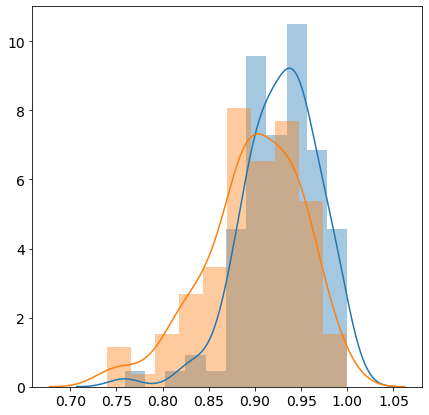

In [726]:
sns.distplot(roc_auc_pull_app['FCN3'], label=key)
sns.distplot(roc_auc_pull_app['all'], label=key)

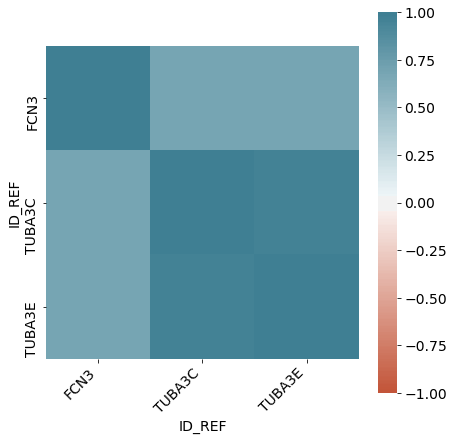

In [1055]:
plot_corr(['FCN3', 'TUBA3C', 'TUBA3E'])

In [1092]:
best_o_best_feature = ['RASD1', 'PRKCD', 'MYH6'] + ['FCN3', 'TUBA3E']

In [1083]:
roc_auc_delTT = dict()
for feature in ['all', 'FCN3', 'TUBA3E']:
    print(feature, '...', sep='')
    if feature != 'all':
        bf = best_o_best_feature.copy()
        key = str()
        bf.remove(feature)
        key = feature
    else:
        key = 'all'
        bf = best_o_best_feature

    Boot = Bootstrap(n_bootstraps=100)

    X = Data.X.train.transpose().filter(bf, axis=1)
    y = np.array(Data.y.train)
    roc_auc = list()
    
    for train, test in Boot.split(X):
        clfStack = clf.fit(X.iloc[train,:], y[train])
        roc_auc.append(metrics.roc_auc_score(y_score=clfStack.predict(X.iloc[test,:]), y_true=y[test]))
    
    roc_auc_delTT[key] = roc_auc

all...
FCN3...
TUBA3E...


In [1084]:
for key in roc_auc_delTT.keys():
    pvalue = stats.mannwhitneyu(roc_auc_delTT[key], roc_auc_delTT['all']).pvalue
    print(key, np.mean(roc_auc_delTT[key]), pvalue, sep='\t')

all	0.9781062017227807	0.4995058016038556
FCN3	0.9703511955209915	0.04778253886307901
TUBA3E	0.9828399884142042	0.013151916566799132


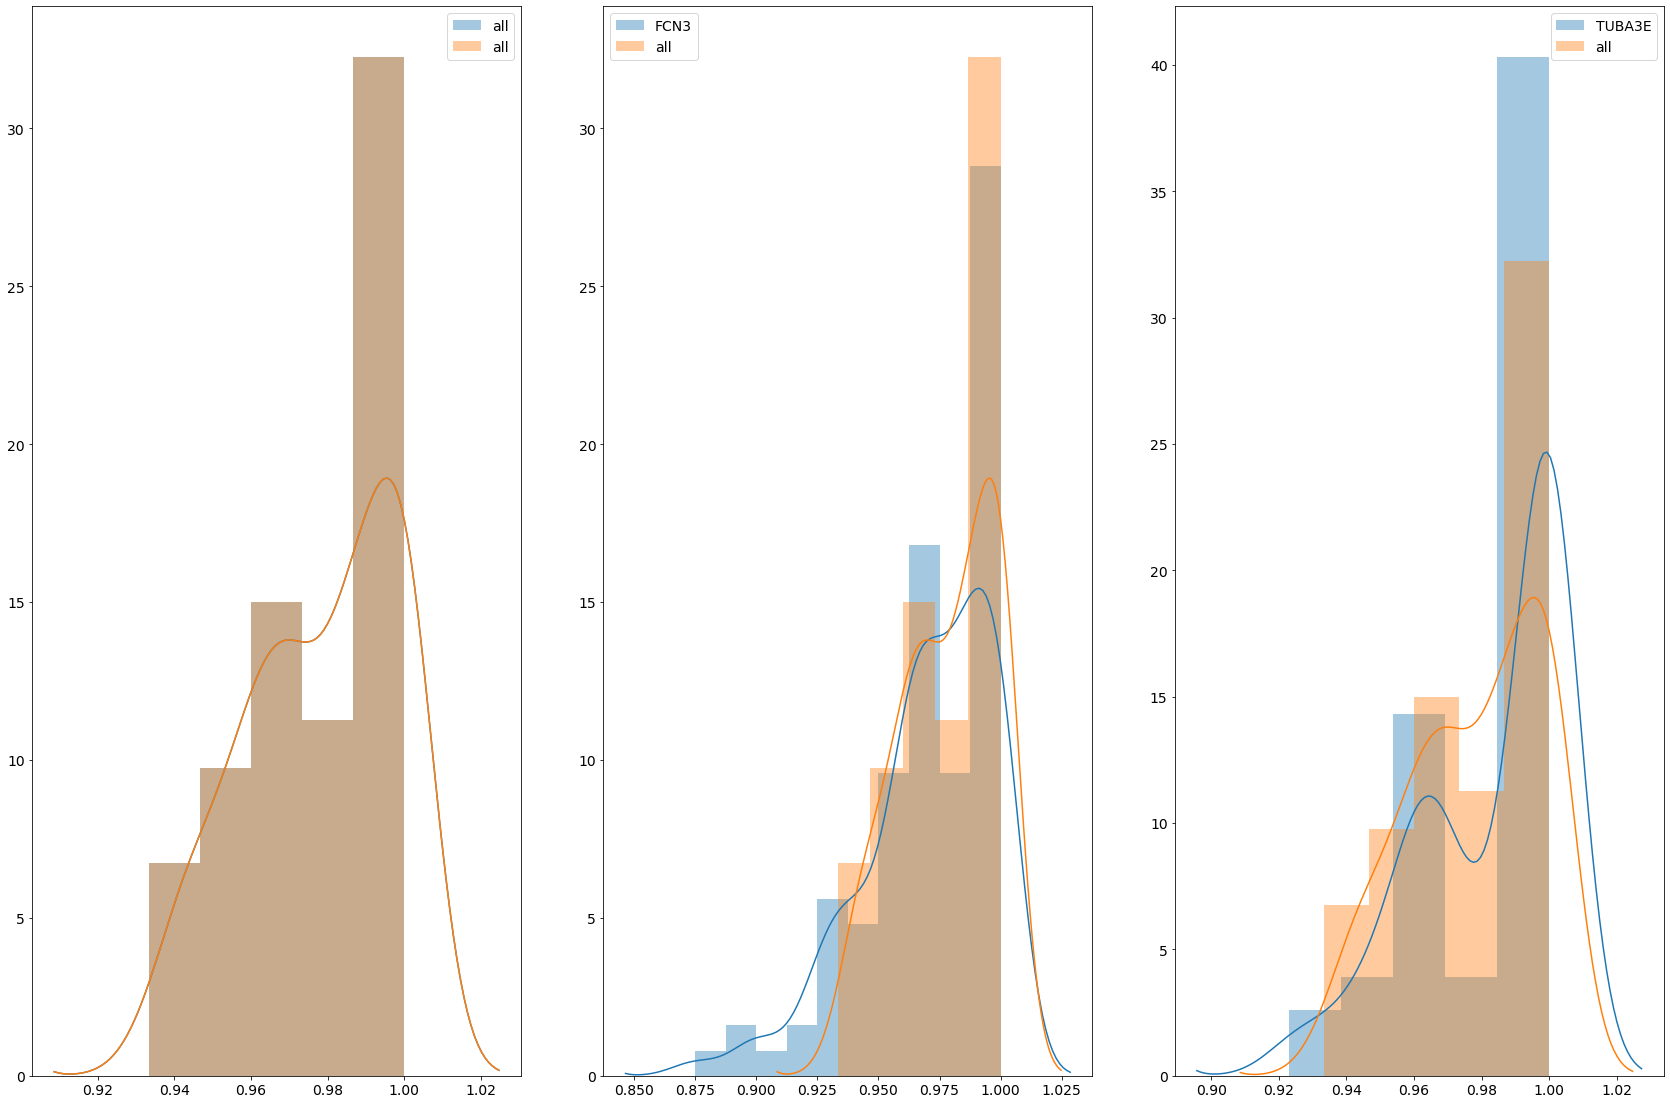

In [1088]:
fig, axes = pyplot.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize = (24,16))
fig.tight_layout(pad = 2, w_pad = 3)

n = 0
for j in range(3):
    key = list(roc_auc_delTT.keys())[n]
    sns.distplot(roc_auc_delTT[key], label=key, ax=axes[j])
    sns.distplot(roc_auc_delTT['all'], label='all', ax=axes[j])
    axes[j].legend()
    n += 1

In [1093]:
best_o_best_feature.remove('TUBA3E')

In [1094]:
print(best_features)
print(best_o_best_feature)

['ZFP36', 'FCN3', 'MT1M', 'RASD1', 'C1R', 'CDC42EP4', 'PRKCD', 'CEBPD', 'TUBA3C', 'MYH6', 'TUBA3E']
['RASD1', 'PRKCD', 'MYH6', 'FCN3']


In [1095]:
roc_auc_pull_app_plus = dict()

for gene in ['all'] + list(gene_weight.keys()):
    
    print(gene, '...', sep='')

    if gene == 'all':
        bf = best_o_best_feature
    elif 0.05 <= gene_weight[gene] < 0.5:
        bf = best_o_best_feature.copy()
        bf.append(gene)
    else:
        continue

    Boot = Bootstrap(n_bootstraps=50)

    X = Data.X.train.transpose().filter(bf, axis=1)
    y = np.array(Data.y.train)
    roc_auc = list()

    for train, test in Boot.split(X):
        clfStack = clf.fit(X.iloc[train,:], y[train])
        roc_auc.append(metrics.roc_auc_score(y_score=clfStack.predict(X.iloc[test,:]), y_true=y[test]))

    roc_auc_pull_app_plus[gene] = roc_auc

all...
RASD1...
TUBA3C...
TUBA3E...
CEBPD...
MT1M...
CDC42EP4...
FCN3...
PRKCD...
MYH6...
ZFP36...
C1R...
LYVE1...
MAP3K6...
TUBA3D...
S1PR3...
CHRDL2...
SERPINA3...
AXUD1...
YPEL2...
S100A9...
CHN1...
MGST1...
DYRK1B...
AP3M2...
PIK3IP1...
TIPARP...
FKBP5...
PIM1...
CD163...
MYC...
FPR1...
BTG2...
CD97...
MT1X...
RANGAP1...
SLA...
LMOD2...
INPP1...
TSPYL2...
SLCO4A1...
PROS1...
SAP18...
NKD2...
ZDHHC9...
GALK1...
KCNK12...
RARRES1...
DDIT3...
MASP1...
MIDN...
IRX6...
CTSC...
SCN2B...
HS.19985...
MT1A...
JAK2...
EBI2...
METTL7B...
CRYM...
FCER1G...
SEC14L1...
IL18R1...
NFKBIZ...
CD209...
FES...
PLA2G2A...
CMTM7...
LOC201140...
IFI30...
CD248...
FGD2...
HES6...
STAT3...
VPS41...
SMAP2...
HCK...
C1QTNF1...
ZGPAT...
LOC653879...
CHST7...
LOC654264...
CYP2J2...
DCLK1...
SLC15A3...
C3...
VSIG4...
MAFB...
SOCS1...
SLC12A9...
SLCO2B1...
C1ORF162...
OSMR...
SELS...
ARPC1B...
MVP...
HOPX...
SORBS2...
ZNF415...
IRX2...
GRASP...
CAPN1...
ALOX5...
LOC255783...
ARS2...
SEMA4B...
FAM110B...
MNS1...


In [1096]:
maybe_gene = list()
for key in roc_auc_pull_app_plus.keys():
    pvalue = stats.mannwhitneyu(roc_auc_pull_app_plus[key], roc_auc_pull_app_plus['all']).pvalue
    print(key, np.mean(roc_auc_pull_app_plus[key]), pvalue,sep='\t')
    
    if pvalue < 0.05 or key == 'all':
        if np.mean(roc_auc_pull_app_plus[key]) > np.mean(roc_auc_pull_app_plus['all']):
            maybe_gene.append(key)

all	0.985467990659403	0.4985161863625598
LYVE1	0.9807996642201076	0.16817657851907092
MAP3K6	0.9782705395381132	0.05178453463801834
TUBA3D	0.9813863956306172	0.04992234332350419
S1PR3	0.9826023643206727	0.4703544162640165
CHRDL2	0.9798592282641709	0.1395617339918654
SERPINA3	0.9684216436379445	0.02016110648714973
AXUD1	0.9795200321500137	0.07301568995483732
YPEL2	0.9861308603677026	0.2903153245331942
S100A9	0.9573373946858574	1.787026114536655e-07
CHN1	0.988133840016193	0.11520002544889846
MGST1	0.9883182639787688	0.18569254494344012
DYRK1B	0.9856878667502911	0.3853102127745261
AP3M2	0.9874565444875043	0.1607088718990201
PIK3IP1	0.9782552947730966	0.19520204972895727
TIPARP	0.9813697926645782	0.15566230692948818
FKBP5	0.9795888975735558	0.11484569652471549
PIM1	0.9814926356719001	0.2213030795060783
CD163	0.9720645899398259	0.02175666555119819
MYC	0.9785803078884711	0.06072056454127028
FPR1	0.9750497673708237	0.028548511408877375
BTG2	0.9808097092587057	0.12578670011727977
CD97	0.984220

In [1097]:
maybe_gene

['LMOD2']

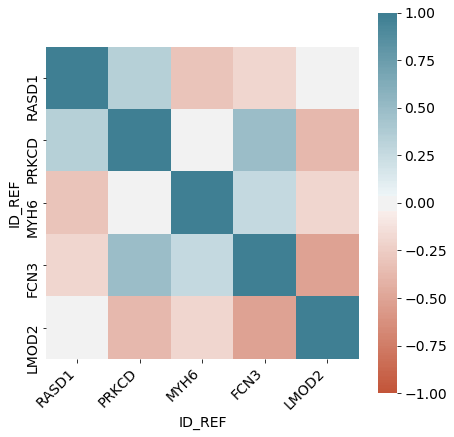

In [1098]:
plot_corr(best_o_best_feature + maybe_gene)

In [1099]:
best_o_best_feature_plus = best_o_best_feature + maybe_gene

In [1100]:
print(*best_o_best_feature)
print(*best_o_best_feature_plus)

RASD1 PRKCD MYH6 FCN3
RASD1 PRKCD MYH6 FCN3 LMOD2


In [1101]:
X = Data.X.train.transpose().filter(best_o_best_feature_plus, axis=1)
y = np.array(Data.y.train)
X = X.iloc[y != 1,:]

In [1102]:
n_col = 5

plots_dot = dict()
for i in range(0, n_col):
    for j in range(i+1, n_col):
        plots_dot[X.columns[i] + '+' + X.columns[j]] = {'y': list(X.iloc[:,i]), 'x': list(X.iloc[:,j])}

IndexError: list index out of range

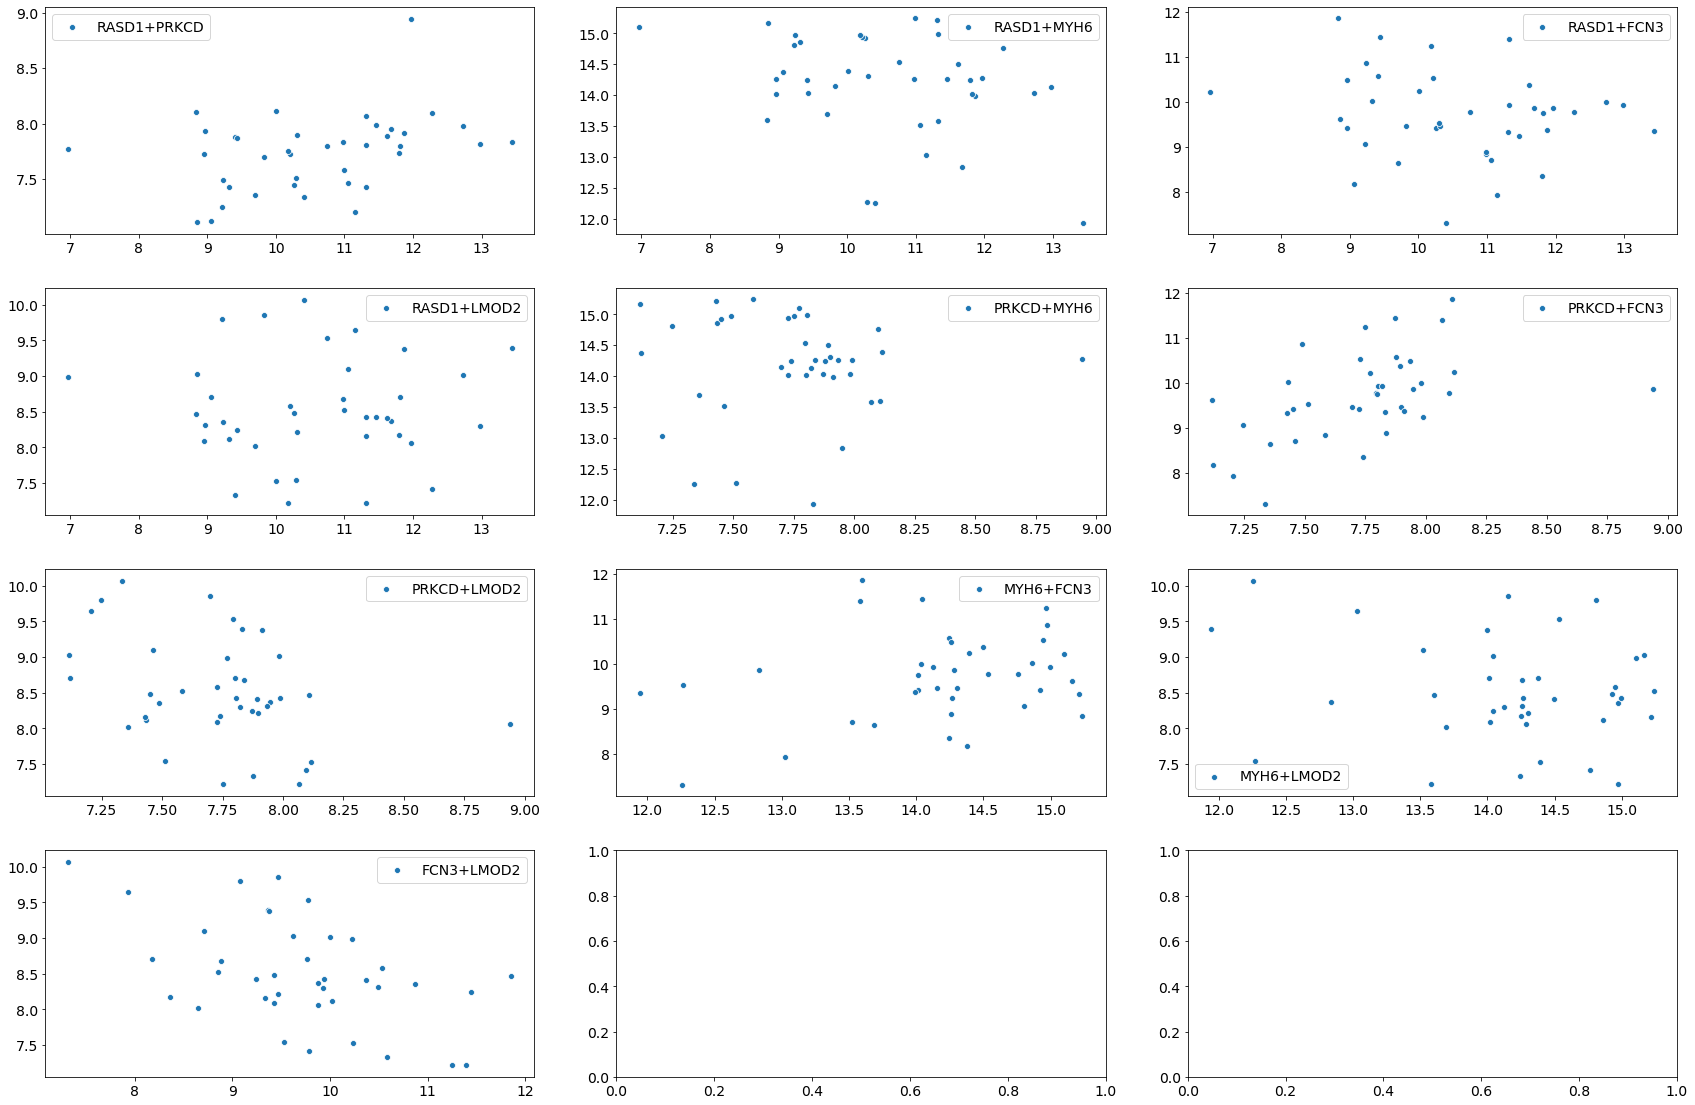

In [1104]:
fig, axes = pyplot.subplots(nrows=4, ncols=3, sharex=False, sharey=False, figsize = (24,16))
fig.tight_layout(pad = 2, w_pad = 3)

n = 0
for i in range(5):
    for j in range(3):
        key = list(plots_dot.keys())[n]
        sns.scatterplot(plots_dot[key]['y'], plots_dot[key]['x'], label = key, ax=axes[i][j])
        axes[i][j].legend()
        n += 1

In [1273]:
pd.DataFrame({'feature': best_o_best_feature}).to_csv('./best_o_best_feature.csv', index_label=False)
pd.DataFrame({'feature': best_o_best_feature_plus}).to_csv('./best_o_best_feature_plus.csv', index_label=False)